2024/4/19

build r0-r'n' Fingerprint with exact FP and normal FP
with n in [1,15]

In the end, we will (usually) pick the 6144 positions with the highest entropy   


In [1]:

import pickle
from pathlib import Path
import time, torch, os
from fingerprint_utils import FP_generator
batch_size=64
import tqdm
import numpy as np
from matplotlib import pyplot as plt
from rdkit.Chem import AllChem
from rdkit import Chem




In [5]:
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors

def generate_FP_with_exact_radius(mol, radius=2, length=6144):

    # Dictionary to store information about which substructures contribute to setting which bits
    bitInfo = {}
    
    # Generate the fingerprint with bitInfo to track the substructures contributing to each bit
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=length, bitInfo=bitInfo)
    
    # Create an array of zeros to represent the new fingerprint
    new_fp = [0] * length
    
    # Filter bitInfo to keep only entries where substructures have the exact radius
    for bit, atoms in bitInfo.items():
        # Check if any substructure at this bit has the exact specified radius
        if any(radius_tuple[1] == radius for radius_tuple in atoms):
            # Set the corresponding bit in the new fingerprint
            new_fp[bit] = 1
    
    # Return the new filtered fingerprint as a list of bits
    return new_fp


def generate_normal_FP(mol, radius=2, length=6144):

    # Dictionary to store information about which substructures contribute to setting which bits
    bitInfo = {}
    
    # Generate the fingerprint with bitInfo to track the substructures contributing to each bit
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=length, bitInfo=bitInfo)
    new_fp = [0] * length
    for bit, atoms in bitInfo.items():
            new_fp[bit] = 1
            
    return new_fp
   


In [6]:

def generate_FP_on_bits_with_exact_radius(mol, radius=2, length=6144):

    # Dictionary to store information about which substructures contribute to setting which bits
    bitInfo = {}
    on_bits = []
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=length, bitInfo=bitInfo)
    # Filter bitInfo to keep only entries where substructures have the exact radius
    for bit, atoms in bitInfo.items():
        # Check if any substructure at this bit has the exact specified radius
        if any(radius_tuple[1] == radius for radius_tuple in atoms):
            # Set the corresponding bit in the new fingerprint
            on_bits.append(bit)
    
    # Return the new filtered fingerprint as a list of bits
    return np.array(on_bits)


def generate_normal_FP_on_bits(mol, radius=2, length=6144):

    # Dictionary to store information about which substructures contribute to setting which bits
    bitInfo = {}
    
    # Generate the fingerprint with bitInfo to track the substructures contributing to each bit
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=length, bitInfo=bitInfo)
    on_bits = np.array(fp.GetOnBits())
    return on_bits

In [10]:
'''This generates exact-r FP and save the count at each position !!!
Gonna take you a few minutes 
'''

os.makedirs(Path('/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles'), exist_ok=True)
def generate_FP_indices_of_r0_r15(split, FP_length, generation_method, dataset="2d"):
    num_plain_FPs = 16
    if generation_method == "exact":
        generate_FP_on_bis = generate_FP_on_bits_with_exact_radius
        save_name = f"Exact_FP_on_bits_r0_r15_len_{FP_length}_{dataset}_{split}.pkl"
    elif generation_method == "normal":
        generate_FP_on_bis = generate_normal_FP_on_bits
        save_name = f"Normal_FP_on_bits_r0_r15_len_{FP_length}_{dataset}_{split}.pkl"
    else:
        raise ValueError("generation_method should be exact or normal")
    if dataset=="2d":
        path_dir = Path("/workspace/SMILES_dataset/")
    elif dataset=="1d":
        path_dir = Path("/workspace/OneD_Only_Dataset/")
    else:
        raise ValueError("dataset should be 2d or 1d")    
    smile_nmr = pickle.load(open(path_dir / split/ "SMILES/index.pkl", "rb"))

    FP_on_bits = {}
    for file_idx, smile_str in tqdm.tqdm(smile_nmr.items()):
        mol = Chem.MolFromSmiles(smile_str)
        mol_H = Chem.AddHs(mol) # add implicit Hs to the molecule
        all_plain_fps = []
        for radius in range(num_plain_FPs):
            all_plain_fps.append(generate_FP_on_bis(mol_H, radius=radius, length=FP_length) + radius*FP_length)
        concated_FP = np.concatenate(all_plain_fps)

        FP_on_bits[file_idx] = concated_FP

    save_dir = Path('/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles')
    
    FP_on_bits_path = save_dir / save_name 
    with open(FP_on_bits_path, 'wb') as f:
        pickle.dump(FP_on_bits, f)
        
    return FP_on_bits

# count = np.zeros(6144*num_plain_FPs)
    
    
    
    # count+= concated_FP
# np.save(f"count_exact_r0_to_r{num_plain_FPs-1}_FP.npy", count)

In [11]:
generate_FP_indices_of_r0_r15("test", 6144, "normal", dataset="2d")
generate_FP_indices_of_r0_r15("val", 6144, "normal", dataset="2d")
generate_FP_indices_of_r0_r15("test", 6144, "normal", dataset="1d")
generate_FP_indices_of_r0_r15("val", 6144, "normal", dataset="1d")


generate_FP_indices_of_r0_r15("test", 1024, "exact", dataset="2d")
generate_FP_indices_of_r0_r15("val", 1024, "exact", dataset="2d")
generate_FP_indices_of_r0_r15("test", 1024, "exact", dataset="1d")
generate_FP_indices_of_r0_r15("val", 1024, "exact", dataset="1d")

print("done")
# DONE

100%|██████████| 22157/22157 [02:07<00:00, 173.42it/s]


done


In [12]:
FP_on_bits_6144_1d_train_normal = generate_FP_indices_of_r0_r15("train", 6144, "normal", dataset="1d")
FP_on_bits_6144_2d_train_normal = generate_FP_indices_of_r0_r15("train", 6144, "normal", dataset="2d")
# DONE 





  0%|          | 180/177662 [00:01<23:28, 126.02it/s]

 89%|████████▊ | 157665/177662 [21:21<02:33, 130.56it/s]

In [6]:
# Done
# FP_on_bits_1024_2d_train_exact = generate_FP_indices_of_r0_r15("train", 1024, "exact", dataset="2d")
# FP_on_bits_1024_1d_train_exact = generate_FP_indices_of_r0_r15("train", 1024, "exact", dataset="1d")

In [12]:
def convert_bits_positions_to_array(FP_on_bits, length):
    FP_on_bits= FP_on_bits.astype(int)
    out = np.zeros(length)
    out[FP_on_bits] = 1
    return out

# Normal_FP_on_bits_r0_r15_len_6144_1d_train = pickle.load(open("/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles/Normal_FP_on_bits_r0_r15_len_6144_1d_train.pkl", "rb"))
# Normal_FP_on_bits_r0_r15_len_6144_2d_train = pickle.load(open("/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles/Normal_FP_on_bits_r0_r15_len_6144_2d_train.pkl", "rb"))

# count_normal = np.zeros(6144*16)
# for FP_on_bits in Normal_FP_on_bits_r0_r15_len_6144_1d_train.values():
#     count_normal += convert_bits_positions_to_array(FP_on_bits, 6144*16)
# for FP_on_bits in Normal_FP_on_bits_r0_r15_len_6144_2d_train.values():
#     count_normal += convert_bits_positions_to_array(FP_on_bits, 6144*16)

# del Normal_FP_on_bits_r0_r15_len_6144_1d_train, Normal_FP_on_bits_r0_r15_len_6144_2d_train


In [8]:

Exact_FP_on_bits_r0_r15_len_1024_2d_train = pickle.load(open("/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles/Exact_FP_on_bits_r0_r15_len_1024_2d_train.pkl", "rb"))
Exact_FP_on_bits_r0_r15_len_1024_1d_train = pickle.load(open("/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles/Exact_FP_on_bits_r0_r15_len_1024_1d_train.pkl", "rb"))


    

In [13]:
count_exact = np.zeros(1024*16)
for FP_on_bits in Exact_FP_on_bits_r0_r15_len_1024_1d_train.values():
    count_exact += convert_bits_positions_to_array(FP_on_bits, 1024*16)
for FP_on_bits in Exact_FP_on_bits_r0_r15_len_1024_2d_train.values():
    count_exact += convert_bits_positions_to_array(FP_on_bits, 1024*16)

In [15]:
len(Exact_FP_on_bits_r0_r15_len_1024_1d_train), len(Exact_FP_on_bits_r0_r15_len_1024_2d_train)

(177662, 109793)

In [17]:
total_size = len(Exact_FP_on_bits_r0_r15_len_1024_1d_train)+ len(Exact_FP_on_bits_r0_r15_len_1024_2d_train)

total_size

287455

In [17]:
"""to show that:
why r0-r4 entropy based works? give more weight to low-radius but high entropy bits 

"""

# r0_r4_indices = np.load("indices_kept_r0_to_r4.npy")

# r0_r4_indices.sort()

# r = [0]*5
# r[0]= r0_r4_indices [r0_r4_indices<6144]
# r[1] = r0_r4_indices [(r0_r4_indices>=6144) & (r0_r4_indices<6144*2)]
# r[2] = r0_r4_indices [(r0_r4_indices>=6144*2) & (r0_r4_indices<6144*3)]
# r[3] = r0_r4_indices [(r0_r4_indices>=6144*3) & (r0_r4_indices<6144*4)]
# r[4] = r0_r4_indices [(r0_r4_indices>=6144*4) & (r0_r4_indices<6144*5)]

# for i in range(4):
#     small_set = set(r[i])
#     large_set = set(r[i+1]-6144)
#     print(len(small_set), len(large_set),len(small_set.intersection(large_set)))
#     print(small_set<=large_set)


In [4]:
# count = np.zeros(2048*5)
# for smile_str in tqdm.tqdm(smile.values()):
#     concat_r2 = FP_generator(smile_str, 4)
    
#     count+= concat_r2
# np.save("count_hyun_r4_FP.npy", count)

In [53]:
# # old code, using radius of inclusion
# hyun_r4_count = np.load("count_hyun_r4_FP.npy")
# r0_to_r4_FP_count = np.load("count_r0_to_r4_FP.npy")
# r0_to_r6_exact_FP_count = np.load("count_exact_r0_to_r6_FP.npy")

In [46]:
# # len(hyun_r4_count), len(r0_to_r4_FP_count)
# count = np.load(f"count_exact_r0_to_r{num_plain_FPs-1}_FP.npy")
# r0_rEND_FP_count = count 
# len(count)

30720

In [47]:
# hyun_fp_count = torch.zeros(6144)
# r2_fp_count = torch.zeros(6144)

# for file in os.listdir(f"{path_dir}/HYUN_FP"):
#     # dataset
#     hyun_fp = torch.load(f"{path_dir}/HYUN_FP/{file}")
#     r2_fp = torch.load(f"{path_dir}/R2-6144FP/{file}")
#     hyun_fp_count+=hyun_fp
#     r2_fp_count+=r2_fp

In [20]:
def compute_entropy(data, use_natural_log=False):
    probability = data/(total_size)
    if use_natural_log:
        entropy = (probability * np.log(np.clip(probability,1e-7 ,1)) )
    else:
        entropy = (probability * np.log2(np.clip(probability,1e-7 ,1)) )
    return entropy

def keep_smallest_entropy(data, size=6144,  use_natural_log=False):
    entropy = compute_entropy(data, use_natural_log)
    indices_of_min_6144 = np.argsort(entropy)[:size]
    # print(entropy, indices_of_min_6144)
    total_entropy = entropy[indices_of_min_6144].sum()
    return total_entropy, indices_of_min_6144



In [55]:
# entropy_hyun_fp, _ = keep_smallest_entropy(hyun_fp_count)
# entropy_r2_fp, _ = keep_smallest_entropy(r2_fp_count)
# entropy_shortened_r0_to_r4_FP, indices_kept_r0_to_r4 = keep_smallest_entropy(r0_to_r4_FP_count)
# entropy_shortened_hyun_r4, indices_kept_hyun_r4 = keep_smallest_entropy(hyun_r4_count)

# entropy_shortened_r0_to_rEND_FP, indices_kept_r0_to_rEND = keep_smallest_entropy(r0_rEND_FP_count)
# entropy_shortened_r0_to_r6_FP, indices_kept_r0_to_rEND = keep_smallest_entropy(r0_to_r6_exact_FP_count)





In [57]:
# # print(f"entropy_hyun_fp: {entropy_hyun_fp}")
# # print(f"entropy_r2_fp: {entropy_r2_fp}")
# print(f"entropy_shortened_r0_to_r4_FP: {entropy_shortened_r0_to_r4_FP}")
# print(f"entropy_shortened_hyun_FP: {entropy_shortened_hyun_r4}")
# print(f"entropy_shortened_r0_to_r{num_plain_FPs-1}_FP_exact_radius: {entropy_shortened_r0_to_rEND_FP}")
# print(f"entropy_shortened_r0_to_r6_FP_exact_radius: {entropy_shortened_r0_to_r6_FP}")

entropy_shortened_r0_to_r4_FP: -776.8895912939214
entropy_shortened_hyun_FP: -483.89706157450036
entropy_shortened_r0_to_r4_FP_exact_radius: -345.7780746562493
entropy_shortened_r0_to_r6_FP_exact_radius: -351.61111574613005


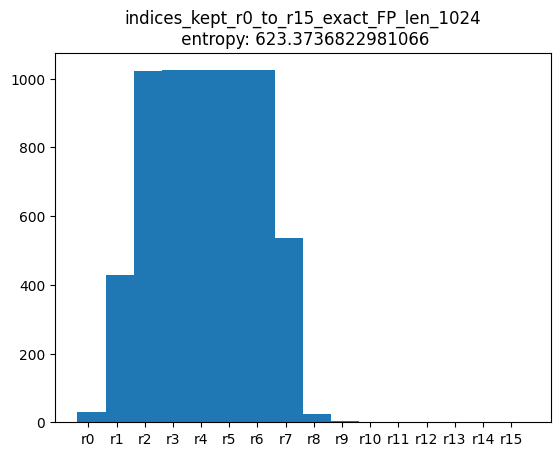

In [62]:
from matplotlib import pyplot as plt

entropy_r0_to_r16_exact, indices_kept = keep_smallest_entropy(count_exact)

# entropy = compute_entropy(data=count_exact, use_natural_log=False)
# np.argsort(entropy)[:6144]

plt.title(f"indices_kept_r0_to_r15_exact_FP_len_1024\n entropy: {entropy_r0_to_r16_exact*-1}")
plt.xticks(np.arange(0,1024*16, 1024)+400, labels=[f"r{r}" for r in range(16)])
_ = plt.hist(indices_kept, bins=np.arange(0,1024*17, 1024))



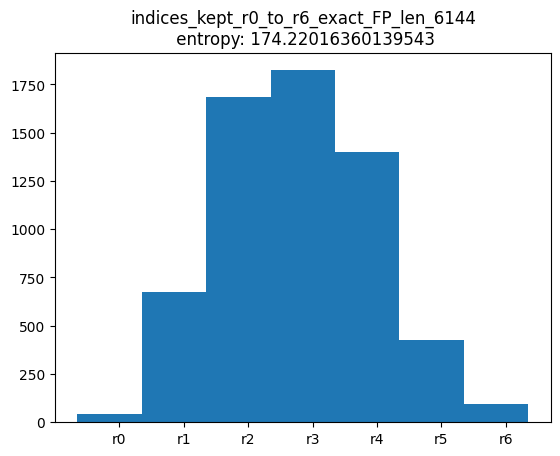

In [59]:
r0_to_r6_exact_FP_count = np.load("count_exact_r0_to_r6_FP.npy")

entropy_r0_to_r7_exact, indices_kept = keep_smallest_entropy(r0_to_r6_exact_FP_count)

# entropy = compute_entropy(data=count_exact, use_natural_log=False)
# np.argsort(entropy)[:6144]

plt.title(f"indices_kept_r0_to_r6_exact_FP_len_6144\n entropy: {entropy_r0_to_r7_exact*-1}")
plt.hist(indices_kept, bins=np.arange(0,6144*8, 6144))
out = plt.xticks(np.arange(0,6144*7, 6144)+4000, labels=[f"r{r}" for r in range(7)])

In [40]:
del Exact_FP_on_bits_r0_r15_len_1024_1d_train, Exact_FP_on_bits_r0_r15_len_1024_2d_train

In [41]:
Normal_FP_on_bits_r0_r15_len_6144_1d_train = pickle.load(open("/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles/Normal_FP_on_bits_r0_r15_len_6144_1d_train.pkl", "rb"))
Normal_FP_on_bits_r0_r15_len_6144_2d_train = pickle.load(open("/root/MorganFP_prediction/reproduce_previous_works/Spectre/notebooks/dataset_building/FP_on_bits_pickles/Normal_FP_on_bits_r0_r15_len_6144_2d_train.pkl", "rb"))

count_normal = np.zeros(6144*16)
for FP_on_bits in Normal_FP_on_bits_r0_r15_len_6144_1d_train.values():
    count_normal += convert_bits_positions_to_array(FP_on_bits, 6144*16)
for FP_on_bits in Normal_FP_on_bits_r0_r15_len_6144_2d_train.values():
    count_normal += convert_bits_positions_to_array(FP_on_bits, 6144*16)

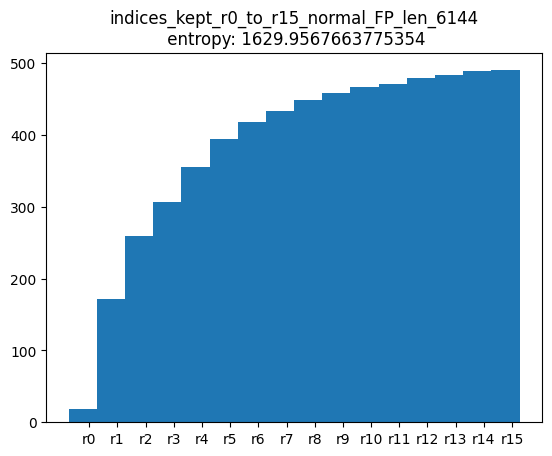

In [61]:
# del Normal_FP_on_bits_r0_r15_len_6144_2d_train, Normal_FP_on_bits_r0_r15_len_6144_1d_train



entropy_r0_to_r16_normal, indices_kept = keep_smallest_entropy(count_normal)

# entropy = compute_entropy(data=count_exact, use_natural_log=False)
# np.argsort(entropy)[:6144]

plt.title(f"indices_kept_r0_to_r15_normal_FP_len_6144\n entropy: {entropy_r0_to_r16_normal*-1}")
plt.hist(indices_kept, bins=np.arange(0,6144*17, 6144))
out = plt.xticks(np.arange(0,6144*16, 6144)+4500, labels=[f"r{r}" for r in range(16)])


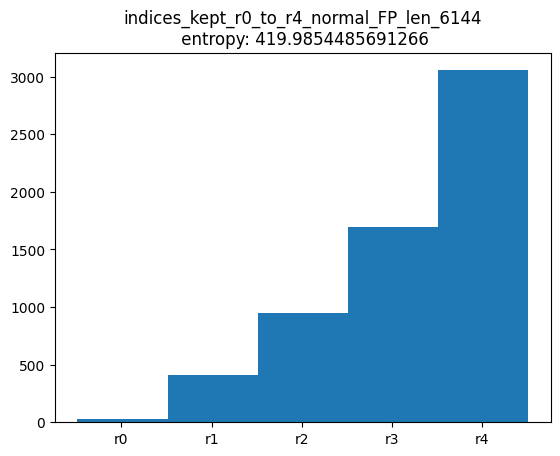

In [63]:
r0_to_r4_normal_FP_count = np.load("count_r0_to_r4_FP.npy")

entropy_r0_to_r4_normal, indices_kept = keep_smallest_entropy(r0_to_r4_normal_FP_count)

# entropy = compute_entropy(data=count_exact, use_natural_log=False)
# np.argsort(entropy)[:6144]

plt.title(f"indices_kept_r0_to_r4_normal_FP_len_6144\n entropy: {entropy_r0_to_r4_normal*-1}")
plt.hist(indices_kept, bins=np.arange(0,6144*6, 6144))
out = plt.xticks(np.arange(0,6144*5, 6144)+3000, labels=[f"r{r}" for r in range(5)])

In [43]:
# which_radius = indices_kept_r0_to_r4//6144
# plt.hist(which_radius,bins=5)
# plt.title("radius_kept_r0_to_r4")

Text(0.5, 1.0, 'Probability of each bit being 1 (old FPs from r0 to r4)')

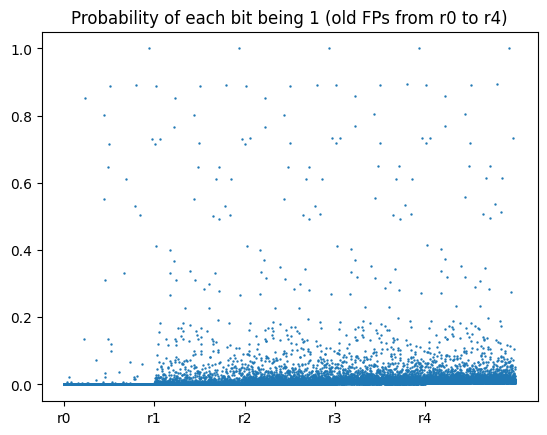

In [73]:
plt.scatter(range(6144*5),r0_to_r4_FP_count/len(smile), s =0.5)
plt.xticks(np.arange(0,6144*5, 6144), labels=[f"r{r}" for r in range(5)])
plt.title("Probability of each bit being 1 (old FPs from r0 to r4)" )

Text(0.5, 1.0, 'Probability of each bit being 1 (old FPs from r0 to r4), after entropy')

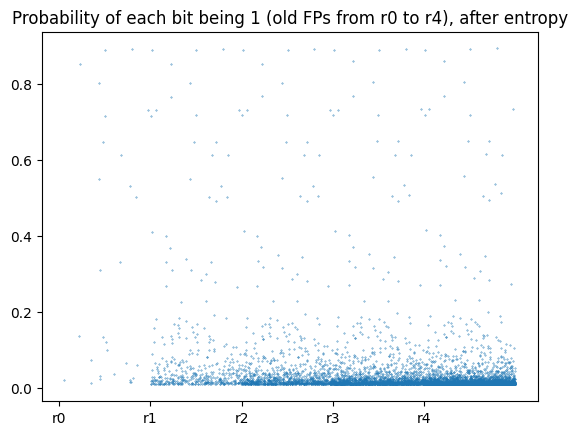

In [71]:
show_only_selected_new = np.array([r0_to_r4_FP_count[i] for i in indices_kept_r0_to_r4])
plt.scatter(indices_kept_r0_to_r4,show_only_selected_new/len(smile), s =0.1)
plt.xticks(np.arange(0,6144*5, 6144), labels=[f"r{r}" for r in range(5)])
plt.title("Probability of each bit being 1 (old FPs from r0 to r4), after entropy" )

Text(0.5, 1.0, 'Probability of each bit being 1 (exact FPs from r0 to r6)')

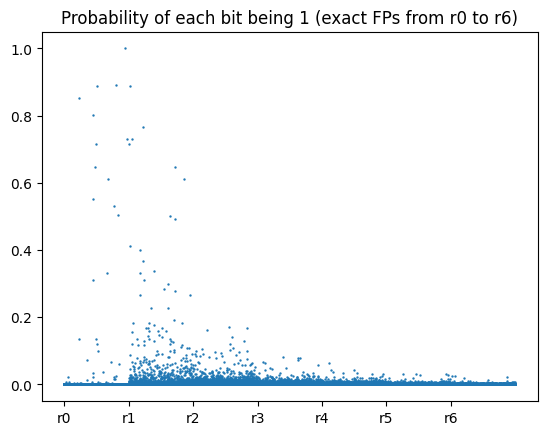

In [74]:
plt.scatter(range(6144*7),count/len(smile), s =0.5)

plt.xticks(np.arange(0,6144*7, 6144), labels=[f"r{r}" for r in range(7)])
plt.title("Probability of each bit being 1 (exact FPs from r0 to r6)" )

In [49]:
indices_kept_r0_to_r6

array([ 7485,  8580,  7217, ..., 27305, 30648, 22947])

Text(0.5, 1.0, 'Probability of each bit being 1 (exact FPs from r0 to r7)')

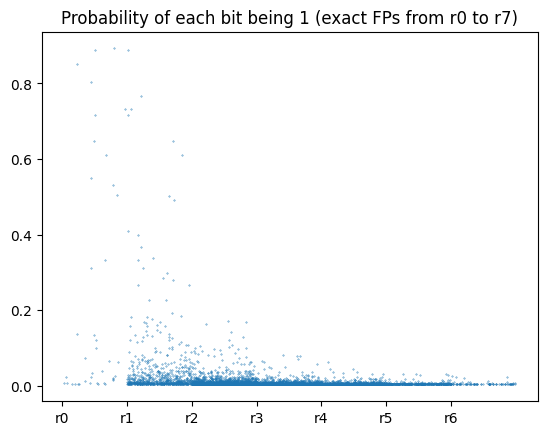

In [67]:
show_only_selected_new = np.array([count[i] for i in indices_kept_r0_to_r6])
plt.scatter(indices_kept_r0_to_r6,show_only_selected_new/len(smile), s =0.1)
plt.xticks(np.arange(0,6144*7, 6144), labels=[f"r{r}" for r in range(7)])
plt.title("Probability of each bit being 1 (exact FPs from r0 to r7)" )

In [76]:
for i in show_only_selected_new/len(smile):
    print(i)

0.3673822556993615
0.37072490960261584
0.37185430765167177
0.37302924594464126
0.3535653456959916
0.3523539752078912
0.3501225032561274
0.34621515032834516
0.34502199593781024
0.34399278642536407
0.33833668813130163
0.33726193837494195
0.3998342335121547
0.40079057863433915
0.33540389642326923
0.402111245707832
0.33401947300829743
0.40345012887889026
0.3327261300811527
0.332434672520106
0.3324255644713233
0.41070013570992686
0.4123851247347281
0.413077336442214
0.41453462424744747
0.3207399378831073
0.3192006776388294
0.31869062690699773
0.3173153115408086
0.31655023544306105
0.314546464710865
0.31099432568560836
0.3109852176368257
0.3109852176368257
0.306713542757735
0.3043545581230133
0.29990983031705115
0.2988897288533877
0.28870693031431877
0.2873589390944778
0.28556465348428406
0.28519122348419296
0.2844443634840108
0.28166640860528447
0.2803093093366608
0.27948047689743427
0.27503574909147216
0.27193901250535096
0.27191168835900287
0.2705454810415965
0.2694798393340195
0.26852349

In [20]:
np.save(f"indices_kept_r0_to_r{num_plain_FPs-1}_new.npy", indices_kept_r0_to_r6)

In [77]:
reduced_count = count[indices_kept_r0_to_r6]
reduced_count.min(), reduced_count.max()

(388.0, 97981.0)

In [78]:
len(reduced_count)

6144

''' compute entropy for each FP '''



In [21]:
def compute_entropy(data):
    probability = data/total_train_samples
    entropy = -(probability * np.log(np.clip(probability,1e-7 ,1)) )
    return torch.sum(entropy/len(data))



In [25]:
import tqdm
for fp in all_fps:
    counts = torch.zeros(len(torch.load(f"/workspace/SMILES_dataset/train/{fp}/0.pt")))
    for f in tqdm.tqdm(os.listdir(f"/workspace/SMILES_dataset/train/{fp}")):
        counts = counts+ torch.load(f"/workspace/SMILES_dataset/train/{fp}/{f}")
    # prob = counts/total_train_samples
    # print(counts)
    avg_entropy = compute_entropy(counts)
    print(f"{fp} has avg entropy: {avg_entropy}")
    # break

  0%|          | 0/109694 [00:00<?, ?it/s]

100%|██████████| 109694/109694 [00:17<00:00, 6253.21it/s]


R2-6144FP has avg entropy: 0.030047358945012093


100%|██████████| 109694/109694 [00:59<00:00, 1838.02it/s]


HYUN_FP has avg entropy: 0.02789202705025673


100%|██████████| 109694/109694 [00:46<00:00, 2380.42it/s]


R0_to_R4_reduced_FP has avg entropy: 0.0876380056142807


100%|██████████| 109694/109694 [01:16<00:00, 1439.02it/s]


R0_to_R4_30720_FP has avg entropy: 0.028658511117100716


100%|██████████| 109694/109694 [00:46<00:00, 2357.31it/s]


R3-6144FP has avg entropy: 0.04435696452856064


100%|██████████| 109694/109694 [00:45<00:00, 2401.26it/s]


R4-6144FP has avg entropy: 0.05598423629999161


100%|██████████| 109694/109694 [00:45<00:00, 2410.41it/s]


R5-6144FP has avg entropy: 0.06416505575180054


100%|██████████| 109694/109694 [00:45<00:00, 2388.46it/s]


R6-6144FP has avg entropy: 0.0695945993065834


100%|██████████| 109694/109694 [00:46<00:00, 2378.04it/s]


R7-6144FP has avg entropy: 0.07342611253261566


100%|██████████| 109694/109694 [00:46<00:00, 2365.26it/s]


R8-6144FP has avg entropy: 0.07608737051486969


100%|██████████| 109694/109694 [00:47<00:00, 2309.14it/s]


R9-6144FP has avg entropy: 0.07797195762395859


100%|██████████| 109694/109694 [00:47<00:00, 2302.22it/s]

R10-6144FP has avg entropy: 0.07936462759971619


In [22]:
compute_entropy(counts)

tensor(0.0300)

In [23]:
len(counts)

6144